# Классификация нуклеотидов на принадлежность к неканоническим спариваниям с помощью Random Forest

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from f723.tools.models.application import group_k_fold
from f723.tools.dataset.features import NucleotideFeaturesExtractor, FeatureVector
from f723.tools.dataset.transformers import join_features, pack_neighbours
from f723.tools.show.classification import show_classification_result
from f723.tools.show.classification import plot_precision_recall_curve

from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

Соберем все понуклеотидные фичи. Пока только для 1 нуклеотида. Не будем включать в фичи его соседей.

In [3]:
nfe = NucleotideFeaturesExtractor(
    nrlist_path='/home/mikhail/bioinformatics/data/nrlist_3.76_3.0A.csv', 
    cif_dir='/home/mikhail/bioinformatics/data/NR_3.0/cif/', 
    out_dir='/home/mikhail/bioinformatics/data/NR_3.0/out/', 
    sec_struct_dir='/home/mikhail/bioinformatics/data/sec_struct', 
    chains_for_classification_path='/home/mikhail/bioinformatics/data/chains_for_classification.json', 
    max_pair_dist=60)

In [4]:
nucleotide_feature_vector = nfe.make_dataset()

100%|██████████| 341/341 [00:47<00:00,  7.23it/s]


In [5]:
feature_vector = join_features(nucleotide_feature_vector)

In [7]:
def make_model():
    return RandomForestClassifier(class_weight='balanced', n_estimators=100, n_jobs=8)

In [8]:
classification_result = group_k_fold(make_model, feature_vector)

(array([0.87578616, 0.65441651]), array([0.82904529, 0.73355818]), array([0.85177499, 0.69173103]), array([9406, 4151]))
(array([0.88349406, 0.67264477]), array([0.83872685, 0.74975915]), array([0.86052862, 0.70911162]), array([9394, 4152]))
(array([0.86385737, 0.72749441]), array([0.84766557, 0.75273339]), array([0.85568488, 0.73989873]), array([8803, 4756]))
(array([0.87663616, 0.7135607 ]), array([0.84285555, 0.76746725]), array([0.85941404, 0.73953293]), array([8979, 4580]))
(array([0.87953942, 0.71646409]), array([0.86095156, 0.74872979]), array([0.87014623, 0.73224167]), array([9227, 4330]))


precision_recall_fscore_support
(array([0.87594334, 0.69737454]), array([0.8437425 , 0.75083072]), array([0.85954144, 0.72311604]), array([45809, 21969]))


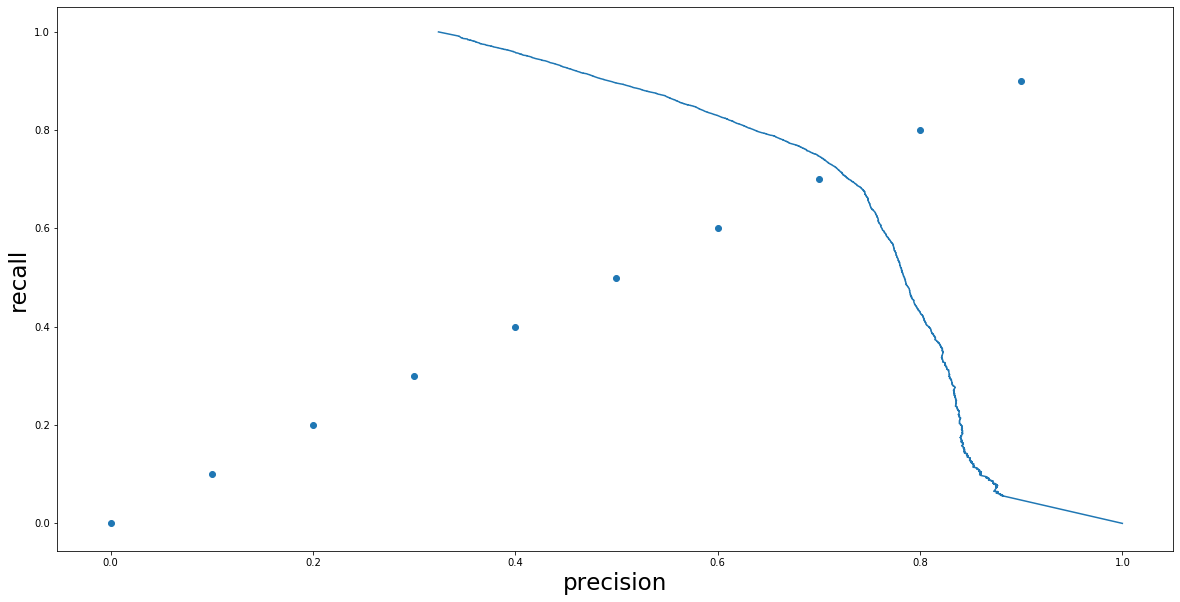

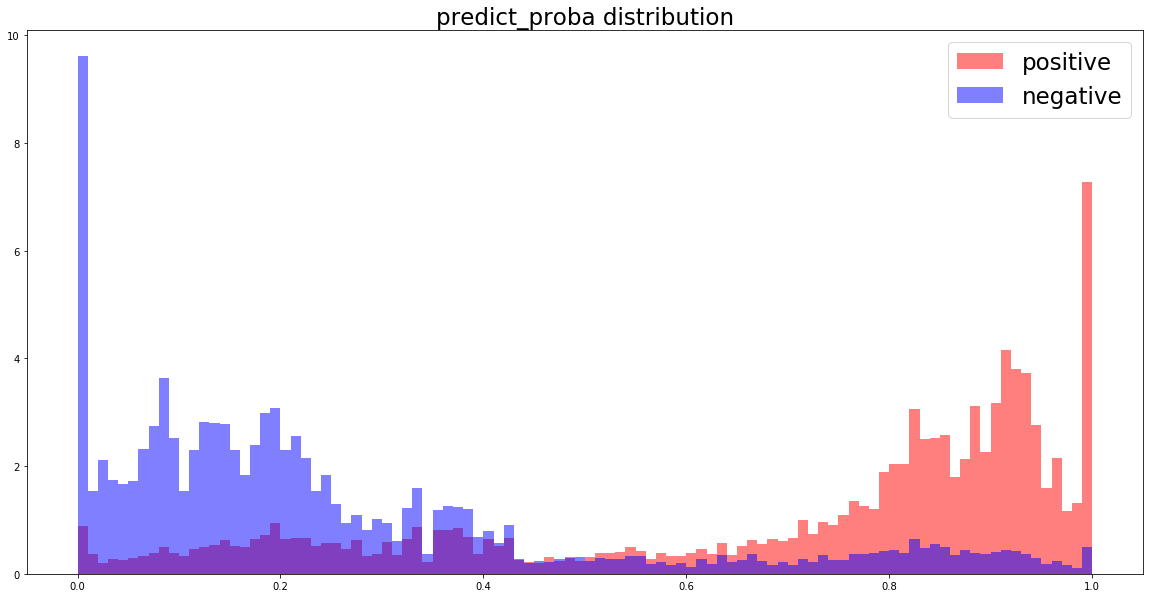

roc auc
0.8542785697700138


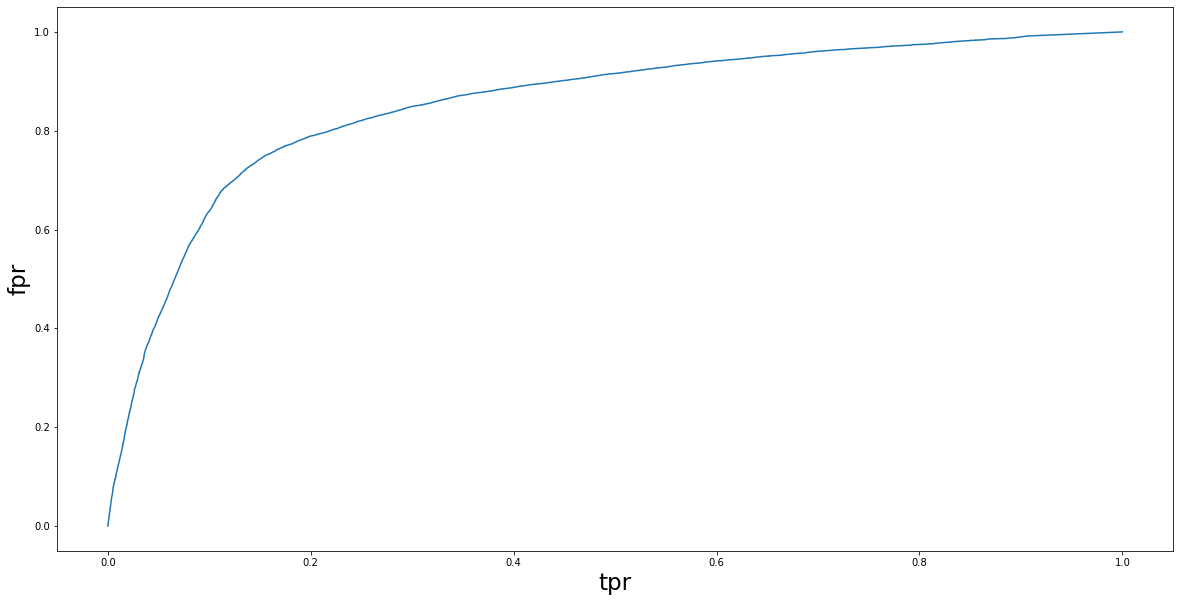

In [9]:
show_classification_result(classification_result)

Добавим по 5 соседей с каждой стороны.

In [10]:
NEIGHBOURS_NUM = 5

In [12]:
neighbours_feature_vector, _ = pack_neighbours(feature_vector, NEIGHBOURS_NUM)
features = neighbours_feature_vector.features
features = features.reshape(len(features), -1)
neighbours_feature_vector = FeatureVector(
    features=features, 
    target=neighbours_feature_vector.target[:, NEIGHBOURS_NUM], 
    pdb_ids=neighbours_feature_vector.pdb_ids)

In [14]:
neighbours_classification_result = group_k_fold(make_model, neighbours_feature_vector)

(array([0.89941589, 0.76899262]), array([0.88810705, 0.78948655]), array([0.8937257 , 0.77910484]), array([8669, 4090]))
(array([0.9035149 , 0.79068651]), array([0.89901563, 0.79893282]), array([0.90125965, 0.79478827]), array([8635, 4123]))
(array([0.89721445, 0.82797357]), array([0.90425401, 0.81646394]), array([0.90072048, 0.82217848]), array([8157, 4604]))
(array([0.90484893, 0.82143642]), array([0.90133495, 0.82725061]), array([0.90308852, 0.82433326]), array([8240, 4521]))
(array([0.90701978, 0.83560311]), array([0.92064796, 0.81037736]), array([0.91378306, 0.82279693]), array([8519, 4240]))


precision_recall_fscore_support
(array([0.9024344 , 0.80936486]), array([0.9026054 , 0.80906479]), array([0.90251989, 0.8092148 ]), array([42220, 21578]))


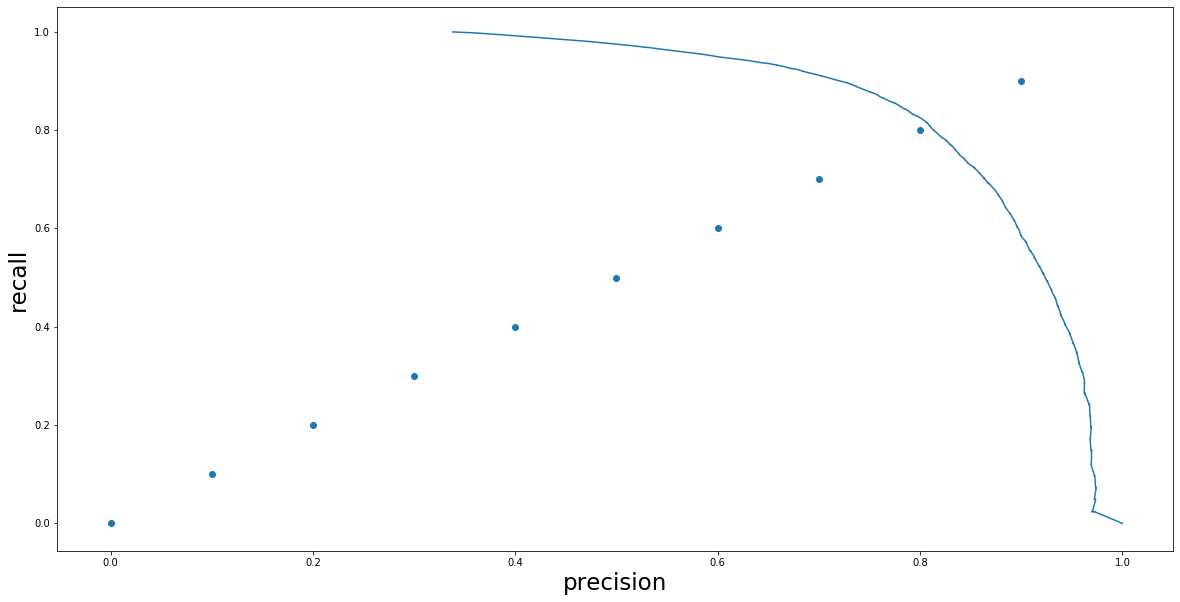

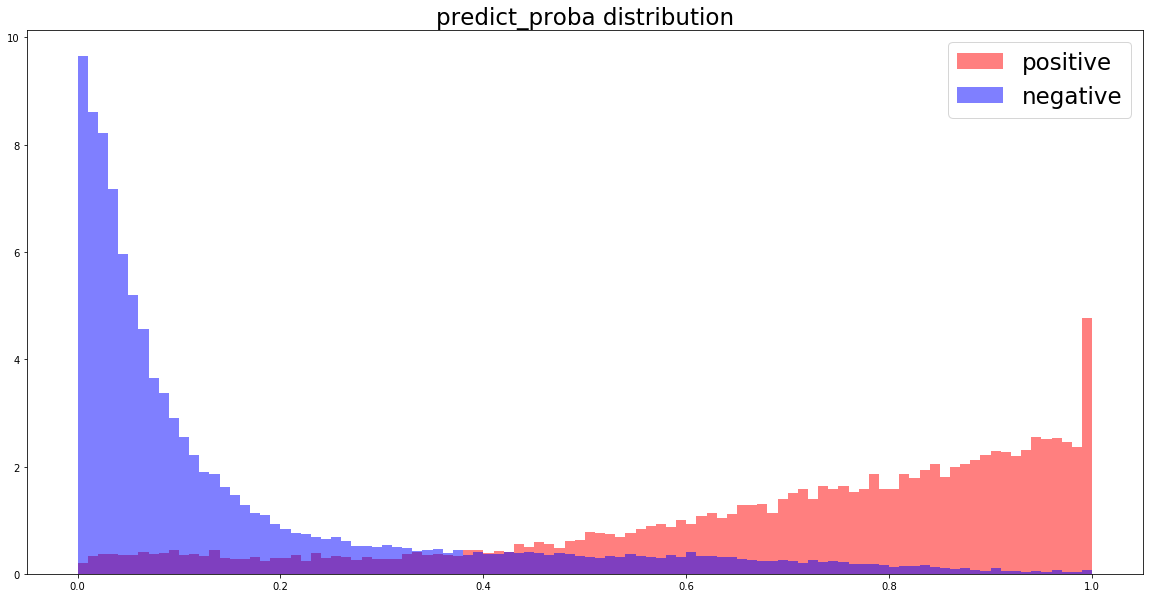

roc auc
0.9303716466439778


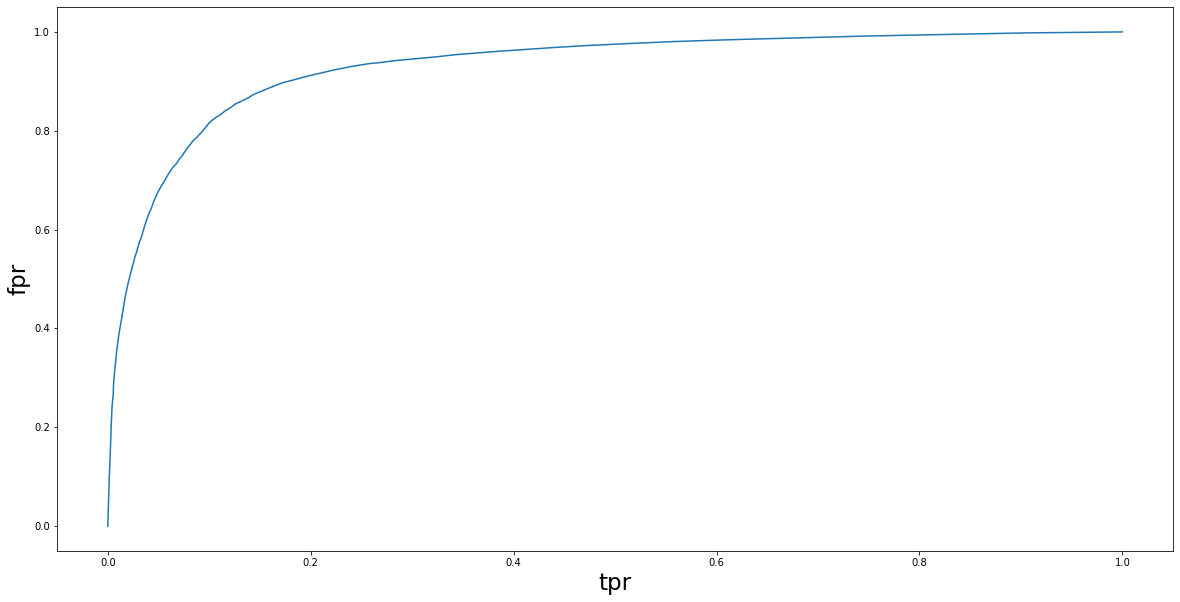

In [15]:
show_classification_result(neighbours_classification_result)

Посмотрим на разницу precision/recall кривых. Без соседей -- синяя кривая, с соседями -- рыжая

precision_recall_fscore_support
(array([0.87594334, 0.69737454]), array([0.8437425 , 0.75083072]), array([0.85954144, 0.72311604]), array([45809, 21969]))
precision_recall_fscore_support
(array([0.9024344 , 0.80936486]), array([0.9026054 , 0.80906479]), array([0.90251989, 0.8092148 ]), array([42220, 21578]))


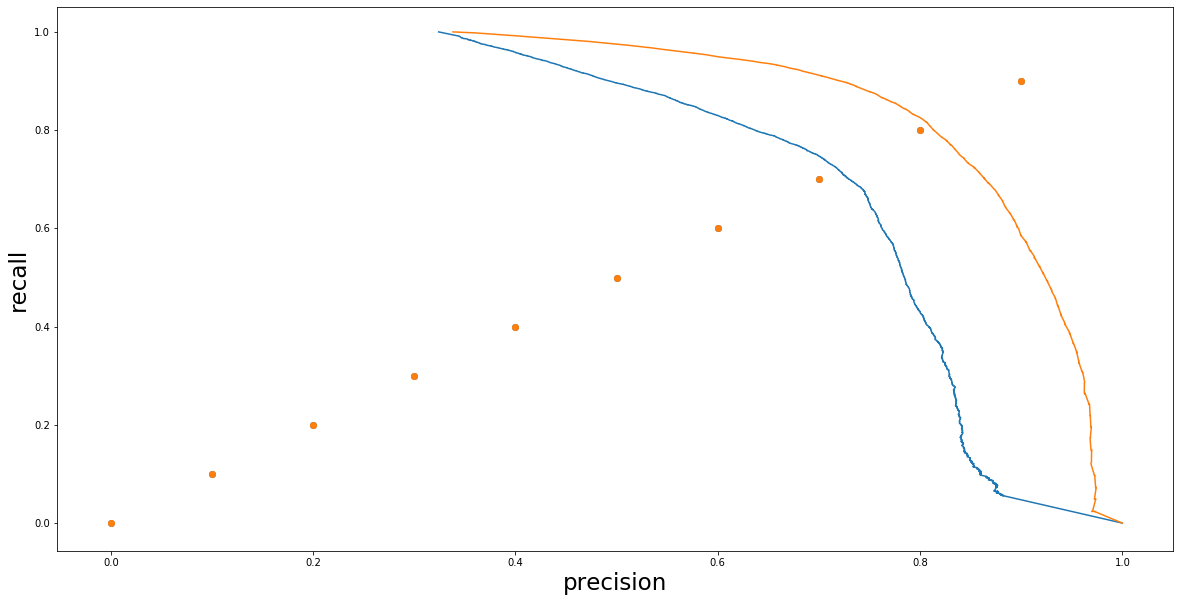

In [16]:
plt.figure(figsize=(20, 10))

plot_precision_recall_curve(classification_result);
plot_precision_recall_curve(neighbours_classification_result);

Вывод: добавление соседей сильно помогает